In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.rcgp import GPRegressor, RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

Optimized length_scale: 0.1298, noise: 0.287613, rbf_variance: 0.1841


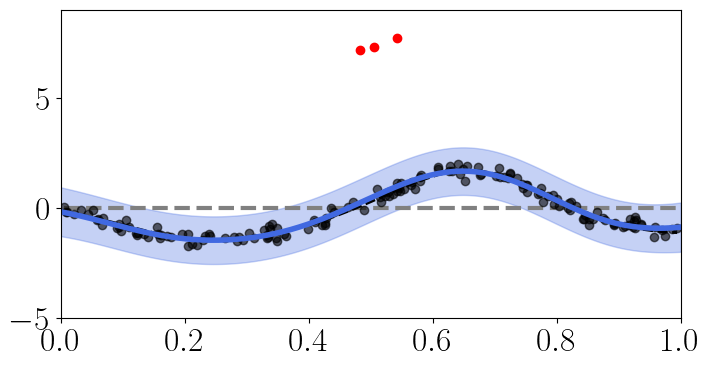

In [4]:
np.random.seed(209)
# Initialisation
epsilon = 0.02
n_points = 160
length_scale = 0.15
variance = 1
noise_variance = 0.04

# Simulation
mean_func = ConstantMean(constant=0)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=variance)

x_train = np.sort(np.random.uniform(0, 1.0, n_points)).reshape(-1, 1)
K_train = rbf_kernel(x_train, x_train)
f_train = np.random.multivariate_normal(mean_func(x_train).flatten(), K_train).reshape(-1, 1)
y_train = f_train + np.random.normal(0, np.sqrt(noise_variance), size=x_train.shape)

# Add outliers
outlier_range = np.where((x_train >= 0.45) & (x_train <= 0.55))[0]
outlier_indices = np.sort(np.random.choice(outlier_range, int(n_points * epsilon), replace=False))
outlier_values = np.random.normal(loc=7, scale=0.5, size=outlier_indices.shape[0])
y_train[outlier_indices] = outlier_values.reshape(-1,1)
# print(outlier_indices)

mean_y_train = np.mean(y_train)
# print(mean_y_train)
y_train = y_train - mean_y_train

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

prior_mean = ConstantMean(constant=0)
rcgp = RCGPRegressor(mean=prior_mean, length_scale=length_scale, rbf_variance=variance, noise=noise_variance, epsilon=epsilon)
rcgp.fit(x_train, y_train)
rcgp.optimize_loo_cv(print_opt_param=True, print_iter_param=False, weighted=True)

mu_true, var_true = rcgp.predict(x_test)
std_true = np.sqrt(var_true + rcgp.noise)

plt.figure(figsize=(8, 4))
plt.plot(x_train, 0 * np.ones(len(x_train)), '--', color='grey', linewidth=3)
plt.plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)
plt.plot(x_train, f_train - mean_y_train, '--', color='black', linewidth=2)
plt.plot(x_test, mu_true.ravel(), color="royalblue")
plt.fill_between(x_test.ravel(), mu_true.ravel() - 1.96 * std_true, mu_true.ravel() + 1.96 * std_true, alpha=0.3, color='royalblue')

# # Plot
# plt.plot(x_train, mean_y_train * np.ones(len(x_train)), '--', color='grey', linewidth=3)
# plt.plot(x_train[mask], y_train[mask], 'o', color='black', markersize=6, alpha=0.6)  # darker grey, slightly transparent
# plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=6)               # red dots
# plt.plot(x_train, f_train, '--', color='black', linewidth=2)                              # thicker true function

plt.ylim(-5, 9)
plt.xlim(0, 1)
plt.show()